In [1]:
# pip install seisbench
# pip install torchinfo

In [2]:
import torch
import numpy as np
import seisbench.models as sbm
import h5py
import matplotlib.pyplot as plt
from torchinfo import summary

/Users/naoi/python_env/seisbench/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
def double_channels(model):
    import torch.nn as nn   
    model.inc = nn.Conv1d(3, 16, kernel_size=7, stride=1, padding='same')
    model.in_bn = nn.BatchNorm1d(16, eps=1e-3)
    
    model.down_branch[0][0] = nn.Conv1d(16, 16, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[0][1] = nn.BatchNorm1d(16, eps=1e-3)
    model.down_branch[0][2] = nn.Conv1d(16, 16, kernel_size=7, stride=4, padding=3, bias=False)  
    model.down_branch[0][3] = nn.BatchNorm1d(16, eps=1e-3)
    
    model.down_branch[1][0] = nn.Conv1d(16, 32, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[1][1] = nn.BatchNorm1d(32, eps=1e-3)
    model.down_branch[1][2] = nn.Conv1d(32, 32, kernel_size=7, stride=4, padding=0, bias=False)  
    model.down_branch[1][3] = nn.BatchNorm1d(32, eps=1e-3)
    
    model.down_branch[2][0] = nn.Conv1d(32, 64, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[2][1] = nn.BatchNorm1d(64, eps=1e-3)
    model.down_branch[2][2] = nn.Conv1d(64, 64, kernel_size=7, stride=4, padding=0, bias=False)  
    model.down_branch[2][3] = nn.BatchNorm1d(64, eps=1e-3)
    
    model.down_branch[3][0] = nn.Conv1d(64, 128, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[3][1] = nn.BatchNorm1d(128, eps=1e-3)
    model.down_branch[3][2] = nn.Conv1d(128, 128, kernel_size=7, stride=4, padding=0, bias=False)  
    model.down_branch[3][3] = nn.BatchNorm1d(128, eps=1e-3)
    
    model.down_branch[4][0] = nn.Conv1d(128, 256, kernel_size=7, stride=1, padding="same", bias=False)  
    model.down_branch[4][1] = nn.BatchNorm1d(256, eps=1e-3)
    
    model.up_branch[0][0] = nn.ConvTranspose1d(256, 128, 7, 4, bias=False)
    model.up_branch[0][1] = nn.BatchNorm1d(128, eps=1e-3)
    model.up_branch[0][2] = nn.Conv1d(256, 128, 7, stride=1,padding="same", bias=False)
    model.up_branch[0][3] = nn.BatchNorm1d(128, eps=1e-3)

    model.up_branch[1][0] = nn.ConvTranspose1d(128, 64, 7, 4, bias=False)
    model.up_branch[1][1] = nn.BatchNorm1d(64, eps=1e-3)
    model.up_branch[1][2] = nn.Conv1d(128, 64, 7, stride=1,padding="same", bias=False)
    model.up_branch[1][3] = nn.BatchNorm1d(64, eps=1e-3)

    model.up_branch[2][0] = nn.ConvTranspose1d(64, 32, 7, 4, bias=False)
    model.up_branch[2][1] = nn.BatchNorm1d(32, eps=1e-3)
    model.up_branch[2][2] = nn.Conv1d(64, 32, 7, stride=1,padding="same", bias=False)
    model.up_branch[2][3] = nn.BatchNorm1d(32, eps=1e-3)

    model.up_branch[3][0] = nn.ConvTranspose1d(32, 16, 7, 4, bias=False)
    model.up_branch[3][1] = nn.BatchNorm1d(16, eps=1e-3)
    model.up_branch[3][2] = nn.Conv1d(32, 16, 7, stride=1,padding="same", bias=False)
    model.up_branch[3][3] = nn.BatchNorm1d(16, eps=1e-3)

    model.out = nn.Conv1d(16, 3, kernel_size=1, stride=1, padding='same')
    
    return model

In [4]:
# load PhaseNetWC model
model = sbm.PhaseNet(phases="PSN", norm="std")
modified_model = double_channels(model)
model.load_state_dict(torch.load('model_PhaseNetWC_JMA.pth'))

# load data (MATLAB v7.3 matfile = HDF5 file)
filename = 'sample_wv.mat'
with h5py.File(filename, 'r') as file:
    # Access data using variable names
    wvdata = file['wv'][()]
wv = wvdata.transpose(2, 1, 0).astype(np.float32)

# standardization
mean = np.mean(wv, axis=2, keepdims=True)
std = np.std(wv, axis=2, keepdims=True)
wv = (wv - mean) / std

# apply model
model.eval()
with torch.no_grad():
    pred  = model(torch.tensor(wv))
pred  = pred.numpy()        


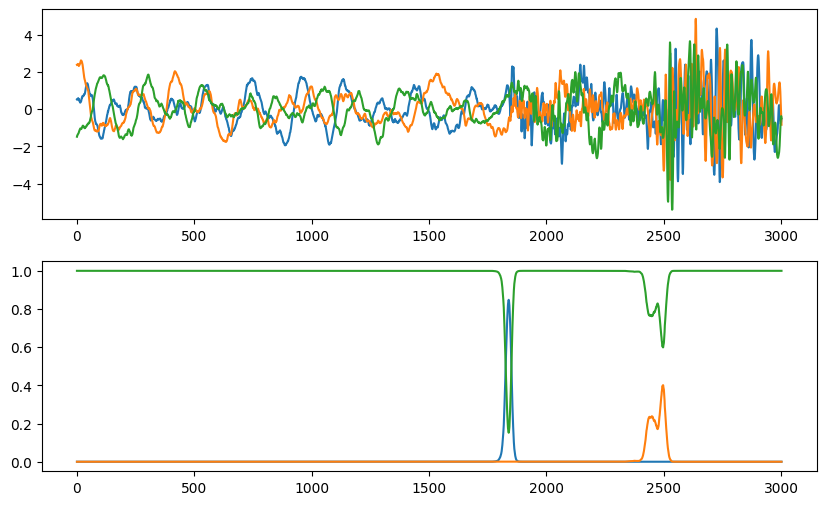

In [5]:
# plot results
wvno = 1
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
axes[0].plot(wv[wvno,:,:].T)
axes[1].plot(pred[wvno,:,:].T);

In [6]:
# Display architecture
summary(model)

Layer (type:depth-idx)                   Param #
PhaseNet                                 --
├─Conv1d: 1-1                            352
├─BatchNorm1d: 1-2                       32
├─ModuleList: 1-3                        --
│    └─ModuleList: 2-1                   --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             32
│    │    └─Conv1d: 3-3                  1,792
│    │    └─BatchNorm1d: 3-4             32
│    └─ModuleList: 2-2                   --
│    │    └─Conv1d: 3-5                  3,584
│    │    └─BatchNorm1d: 3-6             64
│    │    └─Conv1d: 3-7                  7,168
│    │    └─BatchNorm1d: 3-8             64
│    └─ModuleList: 2-3                   --
│    │    └─Conv1d: 3-9                  14,336
│    │    └─BatchNorm1d: 3-10            128
│    │    └─Conv1d: 3-11                 28,672
│    │    └─BatchNorm1d: 3-12            128
│    └─ModuleList: 2-4                   --
│    │    └─Conv1d: 3-13                 57,344
